### Exploratory Data Analysis Challenge

<b>Task</b>


In this exercise, you are given a dataset with claims data. You need to perform an Exploratory Data Analysis and present your results to business users (e.g. interactive dashboard, notebook, or some other tool of your choice).

Business users are interested to see trends and anomalies in the data as well as projections for the upcoming 6 months.



<b>Note:</b> Claims are expenses that insurance companies have to pay for medical services provided to patients.



<b>Dataset</b>

This dataset is a sampled aggregated data for the period of 2018/01 - 2020/07 (numbers are fictional). 

The dataset contains the following columns:

- MONTH - a month claims were lodged
- SERVICE_CATEGORY - a department that provided services to patients
- CLAIM_SPECIALTY - a type of medical services by an official classification system
- PAYER - an insurance company
- PAID_AMOUNT - sum of expenses (claims), $


<b>Requirements</b>
- Python 3+
- Open-source libraries
- [Optional] Use Docker 


<b>Hints</b>
- Kaggle EDA’s as a reference
- Flask / FastAPI / plotly / bokeh / dash / etc.
- Perform any necessary data clean up
- For additional interactivity, you can use filtering data on the fly, pivoting data, etc.

<b>How to submit</b>

Please upload the code for this project to GitHub, post a link to your repository below and give instructions on how to set up a local environment and run your code.



In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import scipy.stats as stats
from collections import Counter
from scipy.stats.stats import pearsonr
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

### General properties of the dataset

In [2]:
data = pd.read_csv('data/claims_sample_data - Sheet1.csv')

In [3]:
data.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937
3,201801,AncillaryFFS,NaN,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


In [4]:
print('Number of rows: ',len(data))

Number of rows:  52152


In [5]:
print('Minimum date: ',min(data.MONTH))

Minimum date:  201801


In [6]:
print('Maximum date: ',max(data.MONTH))

Maximum date:  202007


#### Counting the number of payments by month

In [7]:
cnt = Counter(data.MONTH)

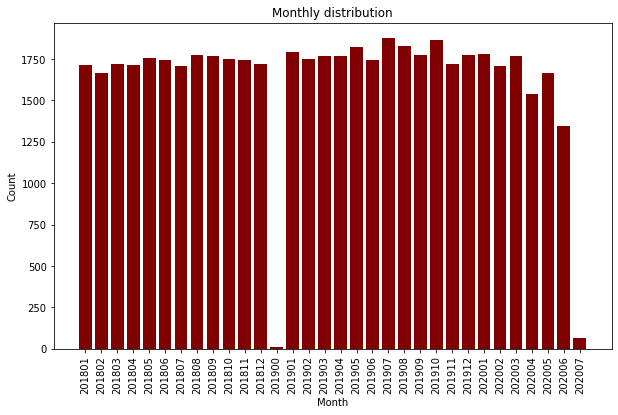

In [8]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly distribution')
plt.show()

<b> Warining! </b> We can see the strange month '201900'. That could be some mistake of writing the data. And we have small amount of payments on '202007'. It seems the month was not ended. We have too small number of payments on these two months so we can just remove them.

In [9]:
data = data[(data.MONTH != 201900) & (data.MONTH != 202007)]

Let's compute all different Service categories

In [10]:
pd.unique(data.SERVICE_CATEGORY)

array(['AncillaryFFS', 'ASCServices', 'ERServices', 'InpatientServices',
       'OutpatientServices', 'PCPEncounter', 'PCPFFS', 'SNFServices',
       'SpecialistFFS', 'SpecialistsFFS'], dtype=object)

In [11]:
cnt = Counter(data.SERVICE_CATEGORY)

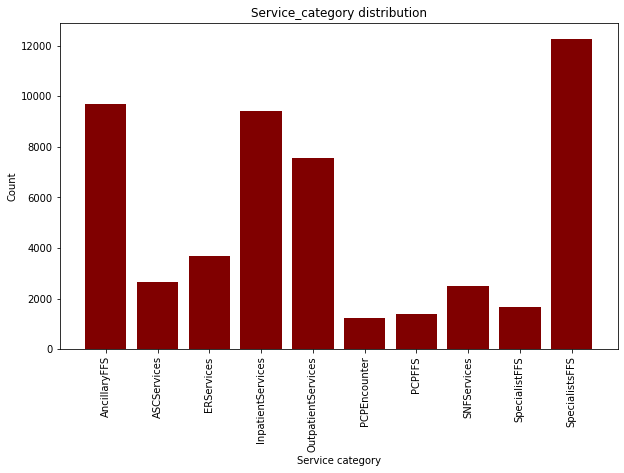

In [12]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Service category')
plt.ylabel('Count')
plt.title('Service_category distribution')
plt.show()

#### Description (from Internet)

- Fee-for-service (FFS) is a payment model in which doctors, hospitals, and medical practices charge separately for each service they perform. In this model, the patient or insurance company is responsible for paying whatever amount the healthcare provider charges for the service.

- Ambulatory Surgical Centers (ASC) Center | CMS

- Ancillary services are supportive or diagnostic measures that supplement and support a primary physician, nurse, or other healthcare provider in treating a patient. Some examples of ancillary services include: Imaging tests (e.g., X-rays, MRI, CT scan, ultrasound) Lab tests. Pharmacies.

- ER (emergency room) - This is probably because the letter E in the hospital setting typically refers to “emergency” (e.g., “ER” for emergency room and “ED” for emergency department).

- A primary care physician (PCP), or primary care provider, is a health care professional who practices general medicine. PCPs are our first stop for medical care. Most PCPs are doctors, but nurse practitioners and physician assistants can sometimes also be PCPs.

- What is an inpatient? In the most basic sense, this term refers to someone admitted to the hospital to stay overnight, whether briefly or for an extended period of time. Physicians keep these patients at the hospital to monitor them more closely.

- With this in mind, what is outpatient care? Also called ambulatory care, this term defines any service or treatment that doesn’t require hospitalization. An annual exam with your primary care physician is an example of outpatient care, but so are emergent cases where the patient leaves the emergency department the same day they arrive. Any appointment at a clinic or specialty facility outside the hospital is considered outpatient care as well.

- Skilled Nursing Facility (SNF) is the full form of SNF medical abbreviation. It’s a rehabilitation center where hospital patients are transferred after leaving the hospital. Seniors usually stay at an SNF for up to 100 days, and licensed medical professionals take care of them while they are there.

<b> Grouping categories. </b> Categories 'SpecialistFFS' and 'SpecialistFFS' seems to be the same category. 'PCPFFS' and 'PCPEncounter' are small categories but as they have the same prefix, we should group them also.

In [13]:
data['SERVICE_CATEGORY'] = ['PCPFFS' if cat == 'PCPEncounter' else cat for cat in data['SERVICE_CATEGORY']]
data['SERVICE_CATEGORY'] = ['SpecialistFFS' if cat == 'SpecialistsFFS' else cat for cat in data['SERVICE_CATEGORY']]

In [14]:
cnt = Counter(data.SERVICE_CATEGORY)

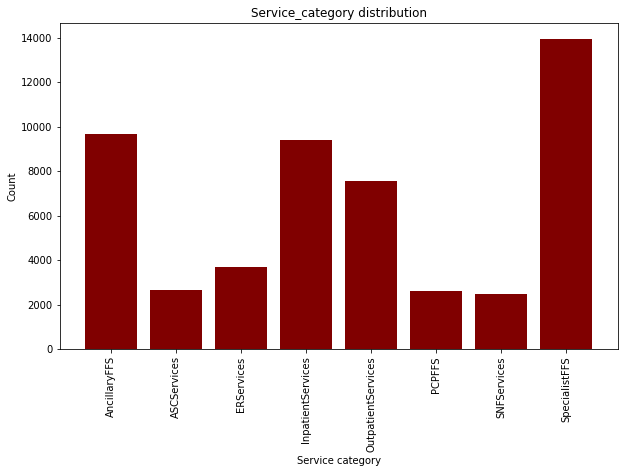

In [15]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Service category')
plt.ylabel('Count')
plt.title('Service_category distribution')
plt.show()

Let's check the data with zero and negative payments.

In [16]:
data[data.PAID_AMOUNT < 0]

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
26,201801,AncillaryFFS,Cardiology,Payer UN,-250
46,201801,AncillaryFFS,Dermatology,Payer UN,-154
102,201801,AncillaryFFS,Geriatric Medicine,Payer UN,-201
103,201801,AncillaryFFS,GERIATRICS,Payer B,-203
144,201801,AncillaryFFS,Internal Medicine,Payer UN,-530
...,...,...,...,...,...
49357,202005,AncillaryFFS,Physician Assistant,Payer UN,-196
49414,202005,AncillaryFFS,Rheumatology,Payer UN,-1374
50158,202005,PCPFFS,FAMILY PRACTICE,Payer CA,-245
50165,202005,PCPFFS,GENERAL PRACTICE,Payer CA,-142


Negative payments could be some kind of refund by court order.

In [17]:
print('Negative payments proportion',len(data[data.PAID_AMOUNT < 0])/len(data))

Negative payments proportion 0.006106694319622076


In [18]:
print('Zero payments proportion',len(data[data.PAID_AMOUNT == 0])/len(data))

Zero payments proportion 0.07385643507316511


In [19]:
print('Positive payments proportion',len(data[data.PAID_AMOUNT > 0])/len(data))

Positive payments proportion 0.9200368706072128


#### Preprocessing of Claim Speciality

In [20]:
print('Proportion of nans in Claim speciality',sum(pd.isna(data.CLAIM_SPECIALTY))/len(data))

Proportion of nans in Claim speciality 0.004820063755424972


In [21]:
print(pd.unique(data.CLAIM_SPECIALTY)[0:50])
print('...')

[nan 'ACH' 'Advanced Registered Nurse Prac' 'ADVANCED RN PRACT'
 'AMBULANCE' 'Ambulance' 'AMBULANCE SERVICE' 'AMBULATORY SURGICAL CENTER'
 'Ambulatory Transportation Services' 'ANATOM' 'ANESTHESIOLOGY' 'ARNP'
 'BEHAVIORAL HEALTH COUNSELING' 'CARD ELECTROPHYSIOLO'
 'CARDIAC ELECTROPHYSIOLOGY' 'CARDIOLOGY' 'Cardiology'
 'Cardiology/Cardiovascular Disease' 'Cardiovascular Medicine'
 'CARDIOVASCULAR SURGERY' 'CCS' 'Chiropractic Medicine'
 'Clinical Medical Laboratory\t' 'Colon and Rectal Surgery'
 'COMMUNITY MENTAL HEALTH CENTER'
 'COMMUNITY MENTAL HEALTH CENTER/OTHER REHAB CENTER' 'CONV CARE CLINIC'
 'COVERING PHYSICIAN' 'CRITICAL ACCESS' 'CSW' 'DEFAULT' 'Dermatology'
 'DERMATOLOGY' 'DERMATOPATHOLOGY' 'Dermatopathology' 'DIABETES EDUCATOR'
 'DIAG X-RAY CLINIC' 'DIAGNOSTIC RADIOLOGY' 'Diagnostics' 'DIAL'
 'DIALYSIS' 'Dialysis' 'DIALYSIS CENTER' 'DISEASE MANAGEMENT'
 'DME & Medical Supplies, Oxygen Equip & Supplies' 'Doctor of Psychology'
 'DURABLE MED EQUIPMENT' 'DURABLE MEDICAL EQUIPMENT'

As we can see different records have different format and contain misprints and abbrevations so we should preprocess the field and indicate popular grouops by hand

In [22]:
data['CLAIM_SPECIALTY_2'] = [' '.join(re.findall('[a-zA-Z]+',str(i))).lower() for i in data['CLAIM_SPECIALTY']]

In [23]:
print(sorted(pd.unique(data.CLAIM_SPECIALTY_2))[0:50])
print('...')

['abulatory surgical center', 'accup', 'ach', 'acupu', 'acupuncturist', 'acute care hospital', 'acute short term hospital', 'addmed', 'addpsy', 'adlmed', 'adolescent medicine', 'advanced heart failure and transplant cardiology', 'advanced registered nurse prac', 'advanced registered nurse practitioner', 'advanced rn pract', 'agencies', 'ahftc', 'allergy', 'allergy immunology', 'ambulance', 'ambulance emergency land', 'ambulance land', 'ambulance service', 'ambulance service provider', 'ambulatory health care', 'ambulatory surgery center', 'ambulatory surgical center', 'ambulatory surgical centers', 'ambulatory surgical facility', 'ambulatory transportation services', 'analytical labs', 'anast', 'anatom', 'anatomic and clinical pathology', 'anatomic path clinical path', 'anatomic pathology', 'anes assist', 'anesthesia', 'anesthesia tee', 'anesthesiologist', 'anesthesiologist assistant', 'anesthesiology', 'anesthesiology pain medicine', 'anesthetist nurse', 'aprn', 'arnp', 'asc', 'audio'

In [24]:
speciality_list = {'allergy & immunology':['allergy','immunology'],
                   'ambulance service':['abulatory','ambulance','ambulatory'],
                   'anatomic':['anatom'],
                   'anesthesia':['anes'],
                   'audiology':['audio'],
                   'bariatric surgery':['baria'],
                   'behavioral':['behavioral'],
                   'blood':['blood'],
                   'cardiology':['card'],
                   'chiropractic medicine':['chiropract'],
                   'colon & rectal':['colon','rectal','proctology'],
                   'community':['community'],
                   'critical care':['critical'],
                   'dental':['dent'],
                   'dermatology':['dermatology'],
                   'diabetes':['diabet'],
                   'diagnostic':['diag'],
                   'dialysis':['dial'],
                   'durable':['durable'],
                   'emergency':['emergency'],
                   'endocrinology':['endocrinology'],
                   'family':['family'],
                   'female pelvic':['fempel','fpmrs'],
                   'gastroenterology':['gastroenterolog'],
                   'general':['general'],
                   'genetics':['genetics','genet'],
                   'geriatric':['geri'],
                   'gynecology':['gyne','ob gyn','obstetrics','obs','pcs','urogyn'],
                   'hematology':['hematology'],
                   'hepatitis':['hepat'],
                   'home':['hha','home'],
                   'hospice':['hospice','hos ancillary'],
                   'hospital':['hospital'],
                   'hyperbaric medicine':['hyper','hypba'],
                   'infectious diseases':['infect'],
                   'infusion':['infusion'],
                   'internal':['internal'],
                   'interventional':['interventional'],
                   'laboratory':['laborator','labs'],
                   'long term':['long term','ltac'],
                   'nephrology':['nephrolog'],
                   'nurse':['nurse','nurprc','nursing'],
                   'mammography':['mammography'],
                   'massage':['massage'],
                   'manipulative therapy':['manipulative'],
                   'mental':['mental','mh','mhh'],
                   'multi specialty':['multi specialty'],
                   'neonatology':['neonatology'],
                   'neurology & neurophysiology':['neuro','neurp'],
                   'neuropsychology':['neuropsycholog'],
                   'nuclear':['nuclear','nucrad'],
                   'occupational':['occupational','occthy'],
                   'oms':['oms'],
                   'oncology':['oncology','oncs'],
                   'opthalmology':['ophthalmology','ophthamology','opthalmology','retina','optometr','vision'],
                   'orthopedic':['orth','sports'],
                   'otolaryngology':['otolaryngology','ent','laryngology'],
                   'pain medicine':['pain'],
                   'palliative care':['pall'],
                   'pathology':['patholog'],
                   'pediatric':['pediatric','pednep','pedneu','pednus','pedort','pedspo'],
                   'pharmacy':['phar'],
                   'phlebotomy':['phlebotomy'],
                   'physical':['physic'],
                   'physiology':['physiolog'],
                   'plastic surgery':['plastic'],
                   'podiatrist':['podiat'],
                   'preventive medicine':['preventive'],
                   'proctology':['proctology'],
                   'prosthetic orthotics':['pros'],
                   'psychiatry':['psychiatr'],
                   'psychology':['psycholog'],
                   'pulmonary':['pulmon'],
                   'radiology':['radiol','x ray','xray','nucrad','nuclear','radiation'],
                   'rehabilitation':['rehab','rehhos'],
                   'rheumatology':['rheumatology'],
                   'sleep':['sleep'],
                   'social':['social','lcsw','lpc'],
                   'speech':['speech'],
                   'sports':['sports'],
                   'spinal cord':['spinal cord'],
                   'surgery':['surg'],
                   'therapy':['therap'],
                   'thoracic':['thoracic'],
                   'transplant surgery':['transplant','trasur'],
                   'trauma surgery':['trauma','tsg','tsurge'],
                   'unclassified':['unclassified','unknown'],
                   'undersea and hyperbaric medicine':['under'],
                   'urgent':['urgent'],
                   'urology':['urology','uroonc'],
                   'vascular':['vascu','vasneu','vasurg'],
                   'woundcare':['wound']}

Making new features from grouped specialities

In [25]:
for key,values in tqdm(speciality_list.items()):
    new_col = []
    for claim in data.CLAIM_SPECIALTY_2:
        result = 0
        for value in values:
            if value in claim:
                result = 1
        new_col.append(result)
        
    data[key] = new_col

100%|██████████| 92/92 [00:02<00:00, 36.16it/s]


In [26]:
data.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,CLAIM_SPECIALTY_2,allergy & immunology,ambulance service,anatomic,anesthesia,audiology,bariatric surgery,behavioral,blood,cardiology,chiropractic medicine,colon & rectal,community,critical care,dental,dermatology,diabetes,diagnostic,dialysis,durable,emergency,endocrinology,family,female pelvic,gastroenterology,general,genetics,geriatric,gynecology,hematology,hepatitis,home,hospice,hospital,hyperbaric medicine,infectious diseases,infusion,internal,interventional,laboratory,long term,nephrology,nurse,mammography,massage,manipulative therapy,mental,multi specialty,neonatology,neurology & neurophysiology,neuropsychology,nuclear,occupational,oms,oncology,opthalmology,orthopedic,otolaryngology,pain medicine,palliative care,pathology,pediatric,pharmacy,phlebotomy,physical,physiology,plastic surgery,podiatrist,preventive medicine,proctology,prosthetic orthotics,psychiatry,psychology,pulmonary,radiology,rehabilitation,rheumatology,sleep,social,speech,sports,spinal cord,surgery,therapy,thoracic,transplant surgery,trauma surgery,unclassified,undersea and hyperbaric medicine,urgent,urology,vascular,woundcare
0,201801,AncillaryFFS,NaN,Payer F,4281,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,201801,AncillaryFFS,NaN,Payer H,2221,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,201801,AncillaryFFS,NaN,Payer O,3937,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,201801,AncillaryFFS,NaN,Payer W,268,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,201801,AncillaryFFS,ACH,Payer W,151,ach,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
#data['sign'] = np.sign(data['PAID_AMOUNT'])

In [28]:
#data.to_excel('claims_preprocessed.xlsx',index=False)

In [29]:
data_negative = data[data.PAID_AMOUNT < 0]
data_null = data[data.PAID_AMOUNT == 0]
data = data[data.PAID_AMOUNT > 0]

## Exploring negative data

In [30]:
print('Number of rows:',len(data_negative))

Number of rows: 318


In [31]:
cnt = Counter(data_negative.MONTH)

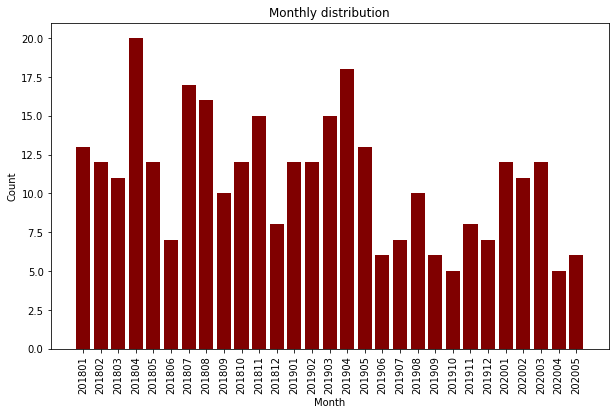

In [32]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly distribution')
plt.show()

In [33]:
cnt = Counter(data_negative.PAYER)

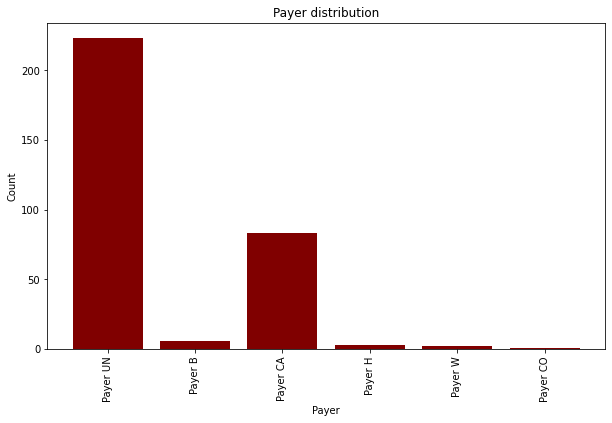

In [34]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Payer')
plt.ylabel('Count')
plt.title('Payer distribution')
plt.show()

In [35]:
cnt = Counter(data_negative.SERVICE_CATEGORY)

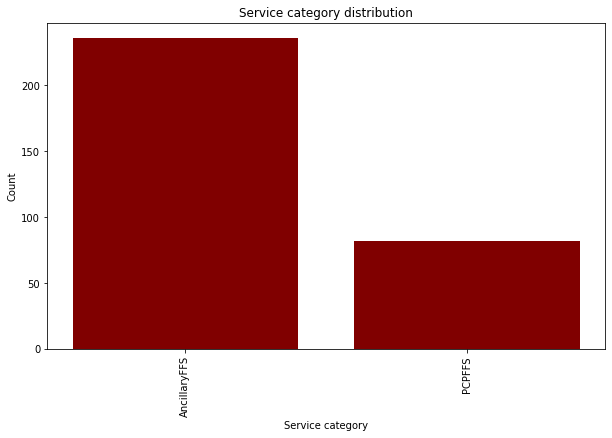

In [36]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Service category')
plt.ylabel('Count')
plt.title('Service category distribution')
plt.show()

As we can see the most part of there payments belongs to 'Payer NU' and 'Payer CA' and two service categories - 'AncillaryFFS' and 'PCPFFS'

## Exploring null data

In [37]:
print('Number of rows:',len(data_null))

Number of rows: 3846


In [38]:
cnt = Counter(data_null.MONTH)

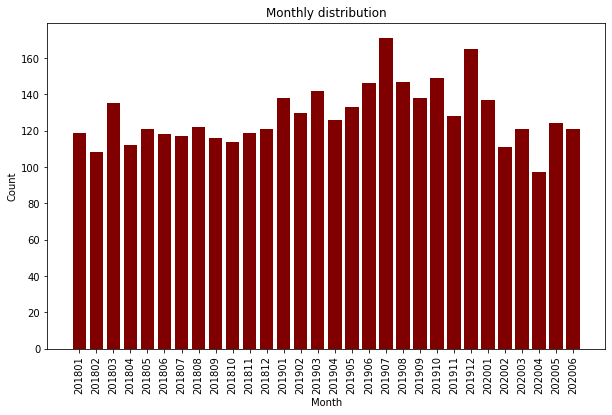

In [39]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly distribution')
plt.show()

In [40]:
cnt = Counter(data_null.PAYER)

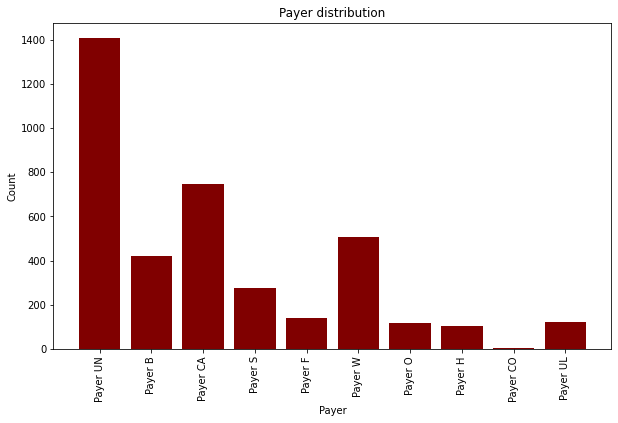

In [41]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Payer')
plt.ylabel('Count')
plt.title('Payer distribution')
plt.show()

In [42]:
cnt = Counter(data_null.SERVICE_CATEGORY)

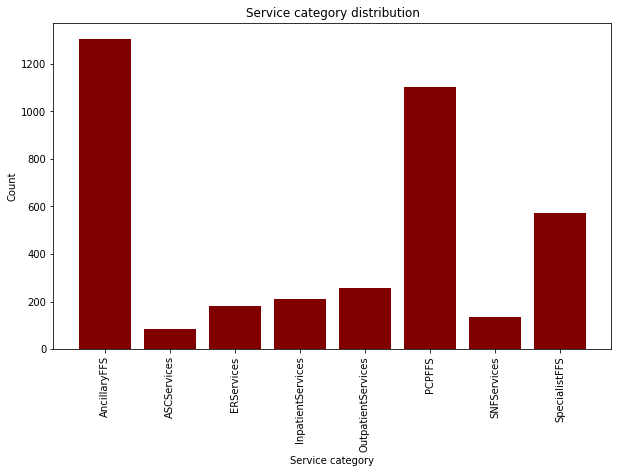

In [43]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Service category')
plt.ylabel('Count')
plt.title('Service category distribution')
plt.show()

For zero payments one can see variety of companies and Service categories

## Exploring positive data

This is the main part because positive payments if a majority of data (over 92%)

#### Pivot table for numer of payments per company per month

In [44]:
data['count'] = 1
pivot = pd.pivot_table(data, values=['count'], index=['PAYER'], columns=['MONTH'], aggfunc=np.count_nonzero).fillna(0)
pivot

count                                                          \
MONTH    201801 201802 201803 201804 201805 201806 201807 201808 201809   
PAYER                                                                     
Payer B    78.0   87.0   85.0   92.0  103.0  110.0  100.0  117.0  104.0   
Payer CA  278.0  254.0  265.0  266.0  275.0  272.0  264.0  269.0  256.0   
Payer CO  135.0  138.0  148.0  142.0  144.0  124.0  127.0  144.0  151.0   
Payer F   291.0  287.0  288.0  290.0  292.0  293.0  279.0  297.0  305.0   
Payer H    70.0   62.0   66.0   62.0   64.0   67.0   68.0   72.0   70.0   
Payer O   209.0  198.0  205.0  213.0  218.0  216.0  218.0  202.0  210.0   
Payer S   161.0  170.0  170.0  169.0  175.0  142.0  136.0  156.0  167.0   
Payer UL    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Payer UN  134.0  137.0  151.0  145.0  147.0  161.0  141.0  147.0  148.0   
Payer W   224.0  211.0  199.0  203.0  208.0  235.0  239.0  233.0  230.0   

                                                                         \
MONTH    201810 201811 201812 201901 201902 201903 201904 201905 201906   
PAYER                                                                     
Payer B   101.0  112.0  107.0  118.0   99.0   92.0   88.0   98.0   93.0   
Payer CA  251.0  266.0  255.0  253.0  251.0  245.0  261.0  257.0  263.0   
Payer CO  161.0  152.0  141.0  134.0  131.0  142.0  130.0  143.0  141.0   
Payer F   306.0  307.0  299.0  299.0  289.0  298.0  306.0  313.0  290.0   
Payer H    65.0   60.0   60.0   74.0   77.0   74.0   79.0   79.0   74.0   
Payer O   209.0  214.0  212.0  224.0  218.0  216.0  203.0  213.0  211.0   
Payer S   162.0  137.0  149.0  129.0  128.0  118.0  110.0  135.0  118.0   
Payer UL    0.0    1.0    1.0   39.0   51.0   47.0   48.0   56.0   42.0   
Payer UN  154.0  151.0  147.0  154.0  148.0  158.0  181.0  165.0  156.0   
Payer W   213.0  213.0  218.0  216.0  217.0  222.0  217.0  218.0  206.0   

                                                                         \
MONTH    201907 201908 201909 201910 201911 201912 202001 202002 202003   
PAYER                                                                     
Payer B   106.0  118.0   91.0  122.0  112.0  116.0  136.0  142.0  135.0   
Payer CA  274.0  281.0  271.0  275.0  267.0  276.0  275.0  285.0  274.0   
Payer CO  143.0  132.0  139.0  147.0  133.0  148.0   52.0   53.0   52.0   
Payer F   297.0  311.0  308.0  327.0  303.0  293.0  302.0  286.0  309.0   
Payer H    74.0   80.0   80.0   75.0   75.0   74.0   81.0   80.0   80.0   
Payer O   211.0  196.0  204.0  216.0  191.0  201.0  204.0  208.0  210.0   
Payer S   129.0  133.0  124.0  120.0  105.0  108.0  109.0  105.0  124.0   
Payer UL   56.0   42.0   40.0   31.0   26.0   20.0   19.0    8.0    8.0   
Payer UN  181.0  154.0  156.0  168.0  148.0  132.0  207.0  201.0  218.0   
Payer W   228.0  224.0  217.0  228.0  227.0  232.0  248.0  221.0  226.0   

                               
MONTH    202004 202005 202006  
PAYER                          
Payer B   110.0  134.0  100.0  
Payer CA  248.0  262.0  162.0  
Payer CO   49.0   51.0   46.0  
Payer F   274.0  286.0  245.0  
Payer H    77.0   80.0   83.0  
Payer O   175.0  192.0  142.0  
Payer S    73.0   92.0   59.0  
Payer UL    9.0   12.0    6.0  
Payer UN  202.0  210.0  196.0  
Payer W   220.0  219.0  184.0

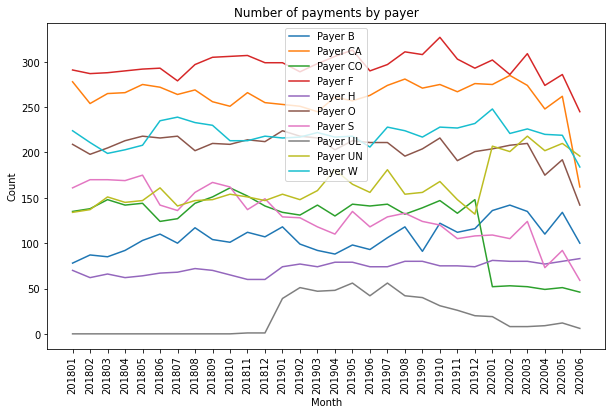

In [45]:
plt.figure(figsize=(10,6))

for i in range(len(pivot)):
    plt.plot(pivot.iloc[i,:].values)
    
plt.legend(pivot.index)
plt.xticks(range(len(pd.unique(data.MONTH))), pd.unique(data.MONTH), rotation=90) 
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of payments by payer')
plt.show()

As one can see 'Payer UL' has less transactions than other payers and the first transaction appears on 201811 

#### Paid_amount distribution

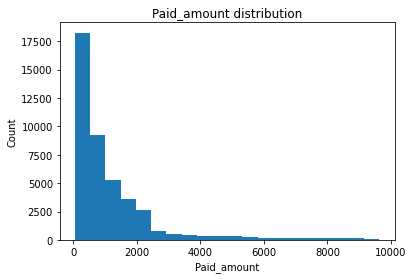

In [46]:
# using interval from percentile 5 to percentile 95
plt.hist(np.array(sorted(data.PAID_AMOUNT.values))[len(data)*5//100:len(data)*95//100],20)
plt.xlabel('Paid_amount')
plt.ylabel('Count')
plt.title('Paid_amount distribution')
plt.show()

Probably paid_amount has log_normal distribution. Let's check it

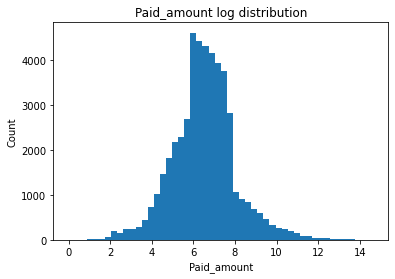

In [47]:
plt.hist(np.log(np.array(sorted(data.PAID_AMOUNT.values))),50)
plt.xlabel('Paid_amount')
plt.ylabel('Count')
plt.title('Paid_amount log distribution')
plt.show()

In [48]:
print('Average of paid_amount:',np.mean(data.PAID_AMOUNT))

Average of paid_amount: 4042.0415988311415


In [49]:
print('Standard deviation of paid_amount:',np.std(data.PAID_AMOUNT))

Standard deviation of paid_amount: 35971.74086297727


In [50]:
print('Standard deviation of paid_amount without outliers:',np.std(np.array(sorted(data.PAID_AMOUNT.values))[len(data)*5//100:len(data)*95//100]))

Standard deviation of paid_amount without outliers: 1464.6181974158987


In the case when the distribution is log-normal, it's better to use median score instead of average because median is not too sensitive to the outliers

In [51]:
print('Median paid_amount:',np.median(data.PAID_AMOUNT))

Median paid_amount: 676.0


The median is very close to the average of log-normal distribution

In [52]:
print('Log-normal average of paid_amount:',np.e**np.mean(np.log(np.array(sorted(data.PAID_AMOUNT.values)))))

Log-normal average of paid_amount: 683.0967826328668


#### Payer distribution

In [53]:
cnt = Counter(data.PAYER)

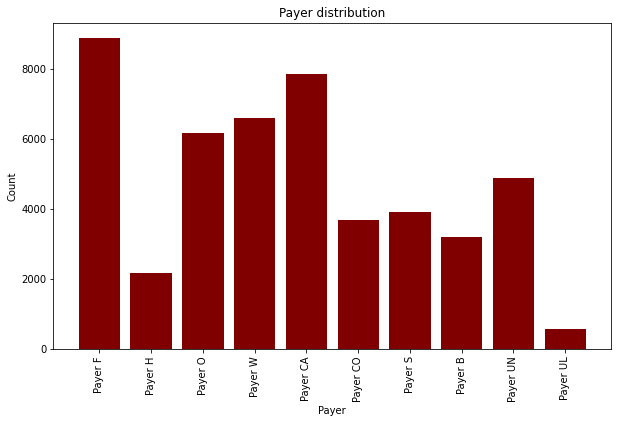

In [54]:
plt.figure(figsize=(10,6))
plt.bar([str(i) for i in cnt.keys()],cnt.values(),color ='maroon',width = 0.8)
plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
plt.xlabel('Payer')
plt.ylabel('Count')
plt.title('Payer distribution')
plt.show()

Computing how many different Service categories each payer has

In [55]:
for payer in pd.unique(data.PAYER):
    temp = data[data.PAYER == payer]
    print(payer,':',len(pd.unique(temp.SERVICE_CATEGORY)))

Payer F : 8
Payer H : 8
Payer O : 8
Payer W : 8
Payer CA : 8
Payer CO : 8
Payer S : 8
Payer B : 8
Payer UN : 8
Payer UL : 8


All 10 payers have all categories

### GOODNESS OF FIT Test

Comparing the distribution of service categories by payer to overall distribution

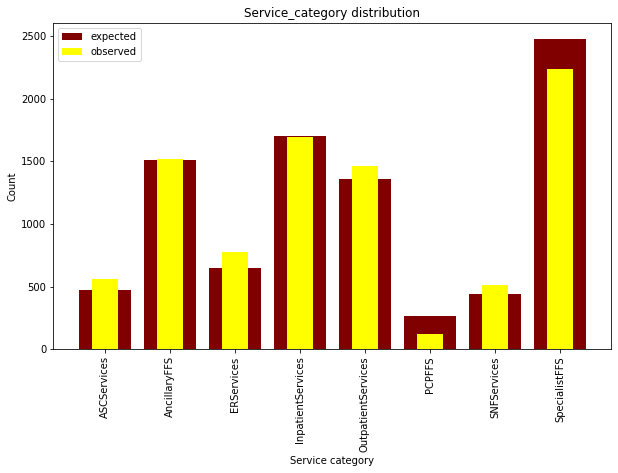

payer: Payer F
chi_square_test_statistic is : 159.11604550451807
p_value : 4.922792044589307e-31
12.591587243743977


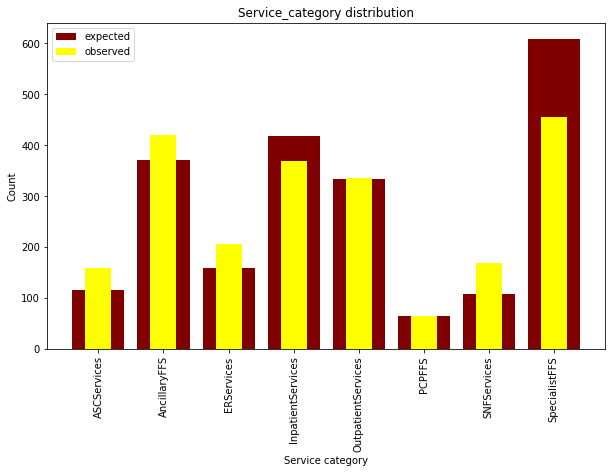

payer: Payer H
chi_square_test_statistic is : 115.792171352185
p_value : 5.753410270783393e-22
12.591587243743977


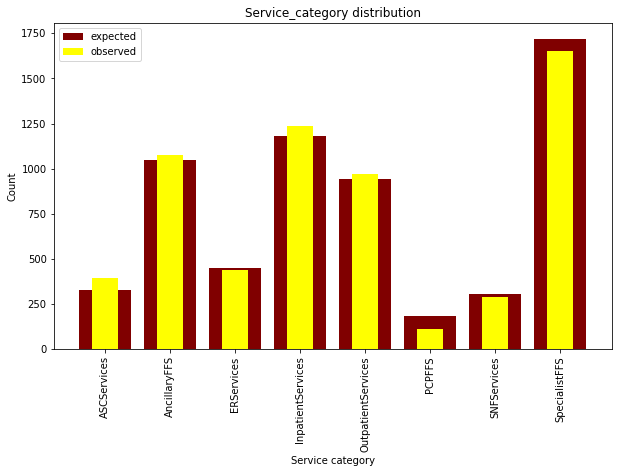

payer: Payer O
chi_square_test_statistic is : 52.34938375375981
p_value : 4.982251437196621e-09
12.591587243743977


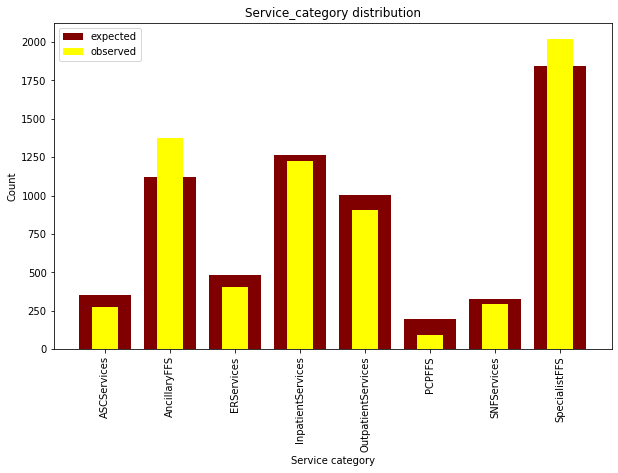

payer: Payer W
chi_square_test_statistic is : 176.0289455086634
p_value : 1.3426989397139578e-34
12.591587243743977


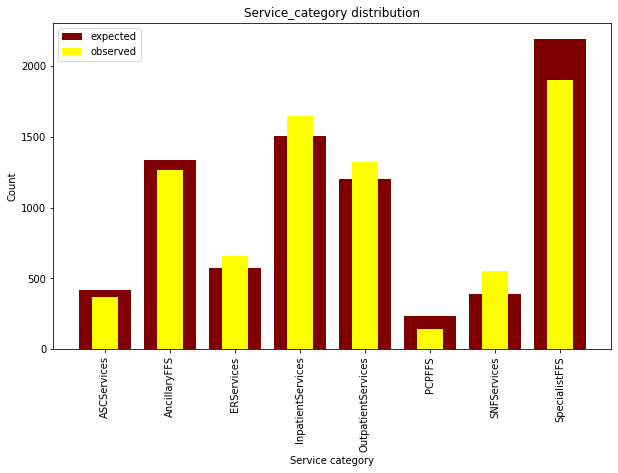

payer: Payer CA
chi_square_test_statistic is : 197.54232751920188
p_value : 3.804057411879403e-39
12.591587243743977


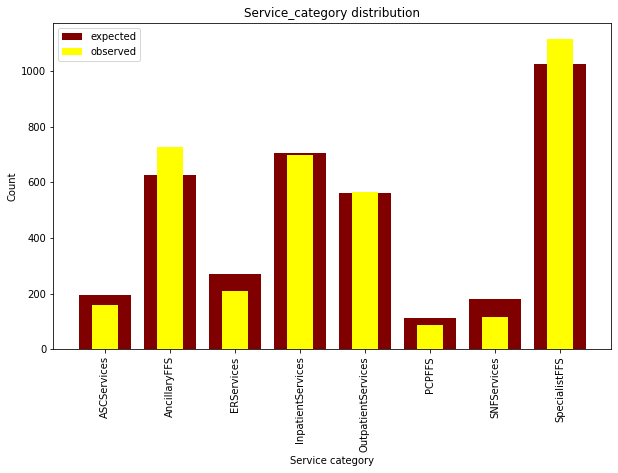

payer: Payer CO
chi_square_test_statistic is : 74.13116577018542
p_value : 2.1525009320621745e-13
12.591587243743977


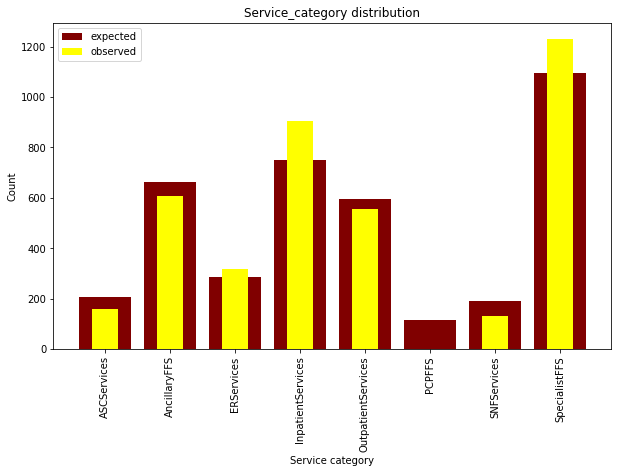

payer: Payer S
chi_square_test_statistic is : 205.22116354002327
p_value : 8.990849221299443e-41
12.591587243743977


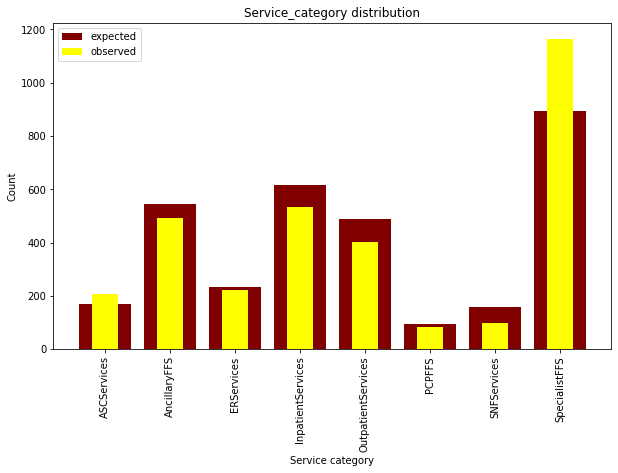

payer: Payer B
chi_square_test_statistic is : 146.63526282809346
p_value : 2.0647085595041257e-28
12.591587243743977


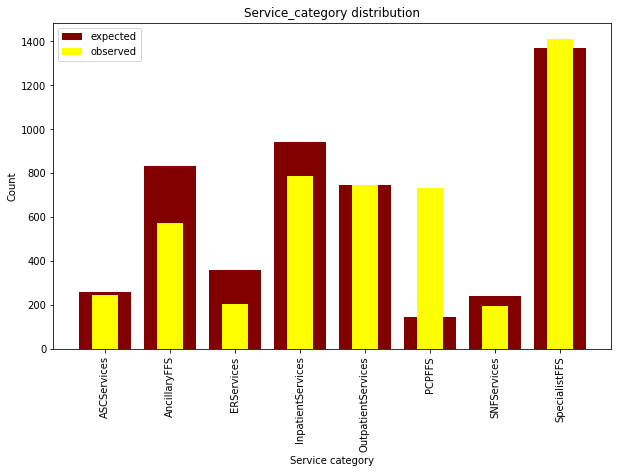

payer: Payer UN
chi_square_test_statistic is : 2508.030453893707
p_value : 0.0
12.591587243743977


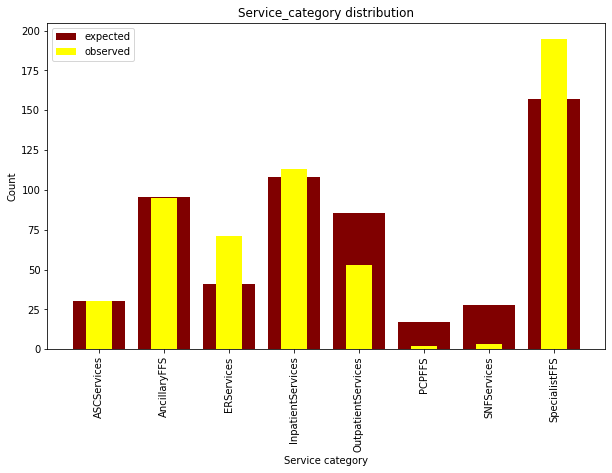

payer: Payer UL
chi_square_test_statistic is : 78.7670210369333
p_value : 2.4569468480583376e-14
12.591587243743977


In [56]:
cnt = Counter(data.sort_values(by='SERVICE_CATEGORY').SERVICE_CATEGORY)
expected_data = np.array(list(cnt.values())) #/sum(cnt.values())

for payer in pd.unique(data.PAYER):
    cnt = Counter(data[data.PAYER == payer].sort_values(by='SERVICE_CATEGORY').SERVICE_CATEGORY)
    observed_data = np.array(list(cnt.values()))

    plt.figure(figsize=(10,6))
    plt.bar([str(i) for i in cnt.keys()],expected_data/sum(expected_data)*sum(observed_data),color ='maroon',width = 0.8)
    plt.bar([str(i) for i in cnt.keys()],observed_data,color ='yellow',width = 0.4)
    plt.xticks(range(len(cnt.keys())), cnt.keys(), rotation=90) 
    plt.xlabel('Service category')
    plt.ylabel('Count')
    plt.title('Service_category distribution')
    plt.legend(['expected','observed'])
    plt.show()
    # Chi-Square Goodness of Fit Test
    chi_square_test_statistic, p_value = stats.chisquare(observed_data, expected_data/sum(expected_data)*sum(observed_data))

    print('payer:',payer)
    # chi square test statistic and p value
    print('chi_square_test_statistic is : ' + str(chi_square_test_statistic))
    print('p_value : ' + str(p_value))

    # find Chi-Square critical value
    print(stats.chi2.ppf(1-0.05, df=6))

In each case we have significant difference but the most visible difference is for 'Payer UN' which has unproportional number of PCP payments

### Payment distribution by payer

Payer: Payer F
Number of rows: 8870
Median paid_amount: 1035.0
Mean paid_amount: 9782.131792559188


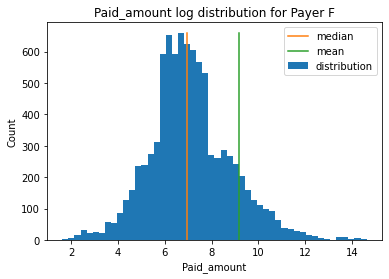

Payer: Payer H
Number of rows: 2182
Median paid_amount: 1245.5
Mean paid_amount: 9956.466086159488


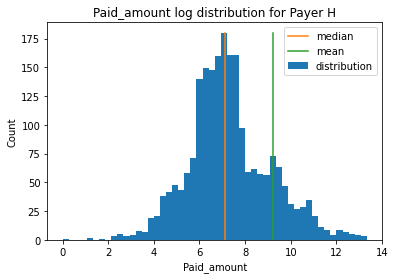

Payer: Payer O
Number of rows: 6159
Median paid_amount: 810.0
Mean paid_amount: 3477.7239811657737


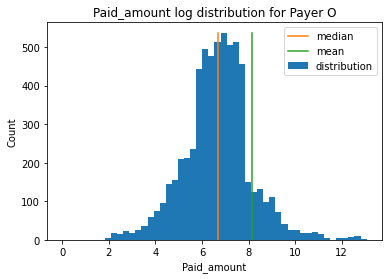

Payer: Payer W
Number of rows: 6596
Median paid_amount: 588.0
Mean paid_amount: 1846.734990903578


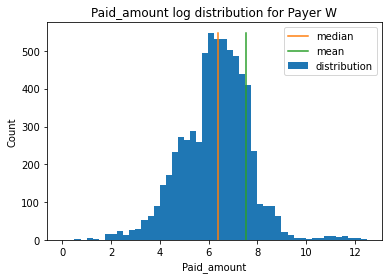

Payer: Payer CA
Number of rows: 7851
Median paid_amount: 757.0
Mean paid_amount: 4291.237804101388


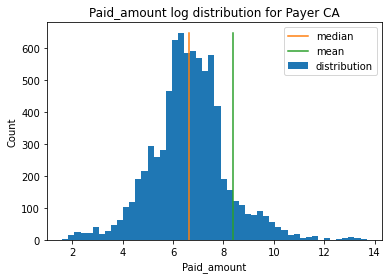

Payer: Payer CO
Number of rows: 3673
Median paid_amount: 607.0
Mean paid_amount: 1380.007078682276


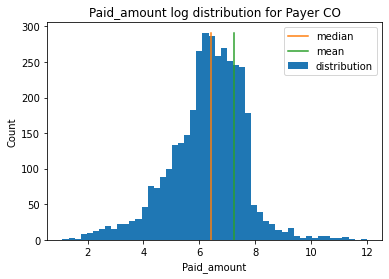

Payer: Payer S
Number of rows: 3913
Median paid_amount: 438.0
Mean paid_amount: 973.8686429849221


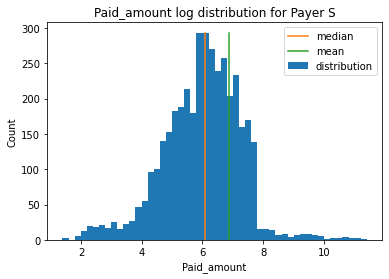

Payer: Payer B
Number of rows: 3206
Median paid_amount: 416.0
Mean paid_amount: 751.426699937617


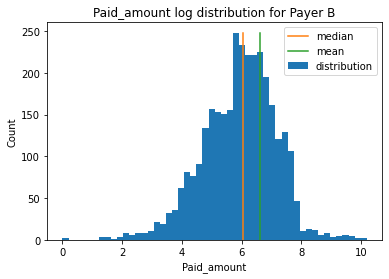

Payer: Payer UN
Number of rows: 4898
Median paid_amount: 544.0
Mean paid_amount: 1280.5647202939977


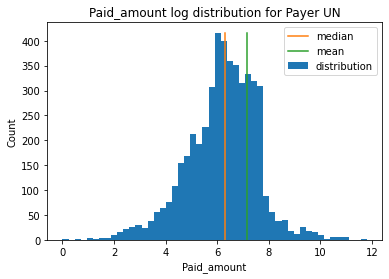

Payer: Payer UL
Number of rows: 562
Median paid_amount: 318.5
Mean paid_amount: 551.6494661921708


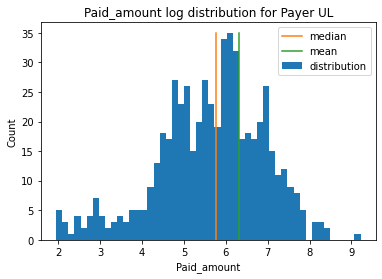

In [57]:
medians = []
means = []

for payer in pd.unique(data.PAYER):
    temp = data[data.PAYER == payer]
    median = np.median(temp.PAID_AMOUNT)
    mean = np.mean(temp.PAID_AMOUNT)    
    medians.append(median)
    means.append(mean)
    print('Payer:',payer)
    print('Number of rows:',len(temp))
    print('Median paid_amount:',median)
    print('Mean paid_amount:',mean)
    plot = plt.hist(np.log(np.array(sorted(temp.PAID_AMOUNT.values))),50)
    plt.plot([np.log(median),np.log(median)],[0,max(plot[0])])
    plt.plot([np.log(mean),np.log(mean)],[0,max(plot[0])])
    plt.xlabel('Paid_amount')
    plt.ylabel('Count')
    plt.title('Paid_amount log distribution for '+payer)
    plt.legend(['median','mean','distribution'])
    plt.show()

Showing that median is more stable statistic

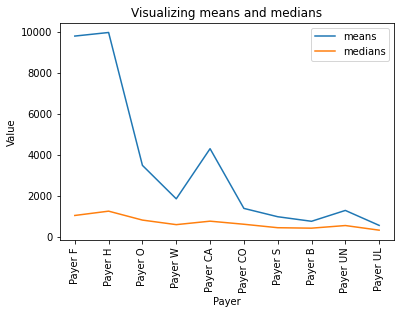

In [58]:
plt.plot(means)
plt.plot(medians)
plt.xlabel('Payer')
plt.ylabel('Value')
plt.title('Visualizing means and medians')
plt.legend(['means','medians'])
plt.xticks(range(len(pd.unique(data.PAYER))), pd.unique(data.PAYER), rotation=90) 
plt.show()

In [59]:
print('Correlarion between means and medians:',pearsonr(medians,means)[0])
print('P-value for correlation coefficient:',pearsonr(medians,means)[1])

Correlarion between means and medians: 0.9510783412495436
P-value for correlation coefficient: 2.3618698414366877e-05


### Exploring top-specialities

#### Top specialities by count

In [60]:
counts = []
for key in speciality_list.keys():
    counts.append(sum(data[key]))

counts = pd.DataFrame({'Speciality':list(speciality_list.keys()),'Count':counts})
counts = counts.sort_values(by='Count',ascending=False).reset_index(drop=True)
counts.head(10)

,Speciality,Count
0,surgery,6047
1,otolaryngology,5490
2,radiology,3701
3,cardiology,3119
4,oncology,2164
5,general,2150
6,physical,1954
7,nurse,1773
8,internal,1739
9,urology,1711


surgery --> corr_coef: 0.032931277007990596 --> p-value: 0.8628445382422639


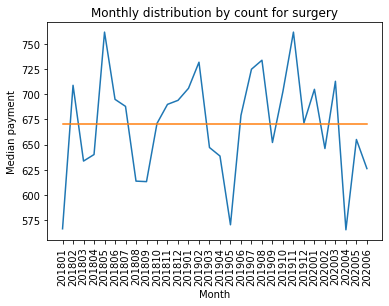

otolaryngology --> corr_coef: -0.3872070810381735 --> p-value: 0.034518822846609766


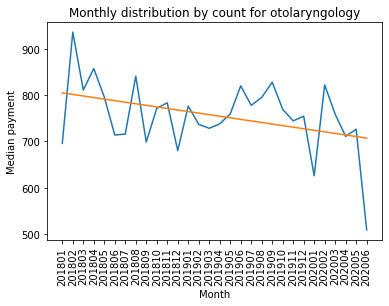

radiology --> corr_coef: 0.319460027017729 --> p-value: 0.08528251216296788


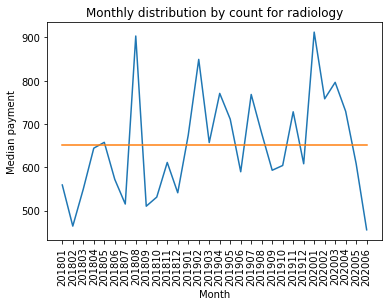

cardiology --> corr_coef: 0.09391273122173291 --> p-value: 0.6215762120784231


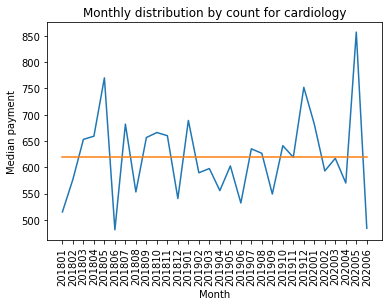

oncology --> corr_coef: 0.3956229330988751 --> p-value: 0.030463878999197228


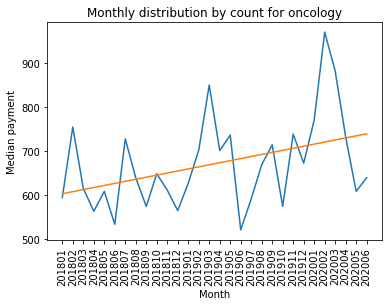

In [61]:
for i in range(5):
    cat = counts.Speciality.values[i]
    avg = []
    for month in sorted(pd.unique(data.MONTH)):
        avg.append(np.median(data[(data.MONTH == month) & (data[cat] == 1)].PAID_AMOUNT))
    plot = pd.DataFrame({'month':list(range(len(pd.unique(data.MONTH)))),'value':avg})
    plot = plot[pd.notna(plot.value)]
    x = plot.month
    y = plot.value
    corr = pearsonr(y,x)
    plt.plot(x,y)
    print(cat,'--> corr_coef:',corr[0],'--> p-value:',corr[1])
    
    plt.xticks(range(len(pd.unique(data.MONTH))), sorted(pd.unique(data.MONTH)), rotation=90) 
    plt.xlabel('Month')
    plt.ylabel('Median payment')
    plt.title('Monthly distribution by count for '+cat)
    
    a = corr[0]*(corr[1]<0.05)*np.std(y)/np.std(x)
    b = np.mean(y)-a*np.mean(x)
    
    y1 = a*min(x)+b
    y2 = a*max(x)+b
    
    plt.plot([min(x),max(x)],[y1,y2])
    
    plt.show()

For the top specialities by count we can see the significant (0.05 threshold) trend for:
- otolaryngology (correlation: -0.39, p_value: 0.03)
- oncology (correlation: 0.39, p_value: 0.03)

#### Top specialities by paid sum

In [62]:
sums = []
for key in speciality_list.keys():
    sums.append(sum(data[data[key] == 1].PAID_AMOUNT))

sums = pd.DataFrame({'Speciality':list(speciality_list.keys()),'Sum_paid':sums})
sums = sums.sort_values(by='Sum_paid',ascending=False).reset_index(drop=True)
sums.head(10)

,Speciality,Sum_paid
0,hospital,41863179
1,otolaryngology,10368734
2,oncology,9718748
3,surgery,9039850
4,radiology,8190466
5,cardiology,7504275
6,hematology,6291089
7,internal,4966067
8,ambulance service,3664576
9,nurse,3554506


hospital --> corr_coef: 0.45885957745161543 --> p-value: 0.010757221768815231


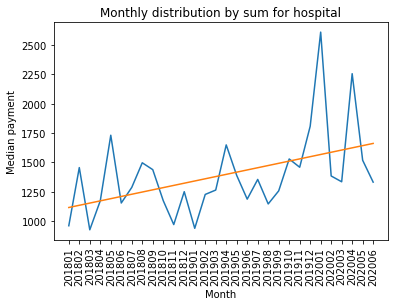

otolaryngology --> corr_coef: -0.3872070810381735 --> p-value: 0.034518822846609766


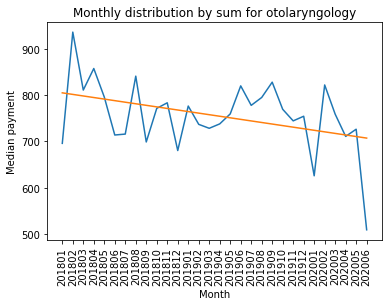

oncology --> corr_coef: 0.3956229330988751 --> p-value: 0.030463878999197228


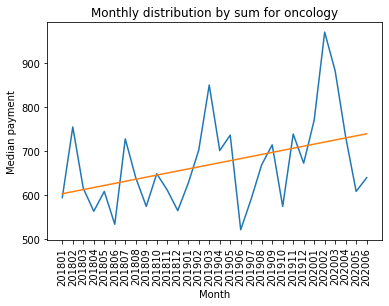

surgery --> corr_coef: 0.032931277007990596 --> p-value: 0.8628445382422639


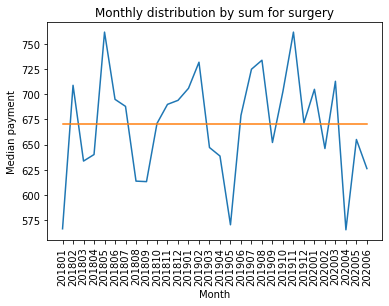

radiology --> corr_coef: 0.319460027017729 --> p-value: 0.08528251216296788


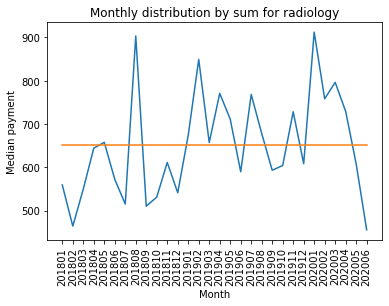

In [63]:
for i in range(5):
    cat = sums.Speciality.values[i]
    avg = []
    for month in sorted(pd.unique(data.MONTH)):
        avg.append(np.median(data[(data.MONTH == month) & (data[cat] == 1)].PAID_AMOUNT))
    plot = pd.DataFrame({'month':list(range(len(pd.unique(data.MONTH)))),'value':avg})
    plot = plot[pd.notna(plot.value)]
    x = plot.month
    y = plot.value
    corr = pearsonr(y,x)
    plt.plot(x,y)
    print(cat,'--> corr_coef:',corr[0],'--> p-value:',corr[1])
    
    plt.xticks(range(len(pd.unique(data.MONTH))), sorted(pd.unique(data.MONTH)), rotation=90) 
    plt.xlabel('Month')
    plt.ylabel('Median payment')
    plt.title('Monthly distribution by sum for '+cat)
    
    a = corr[0]*(corr[1]<0.05)*np.std(y)/np.std(x)
    b = np.mean(y)-a*np.mean(x)
    
    y1 = a*min(x)+b
    y2 = a*max(x)+b
    
    plt.plot([min(x),max(x)],[y1,y2])
    
    plt.show()

For the top specialities by sum we can see the significant (0.05 threshold) trend for:
- hospital (correlation: 0.46, p_value: 0.01)
- otolaryngology (correlation: -0.39, p_value: 0.03)
- oncology (correlation: 0.40, p_value: 0.03)

#### Top specialities by median

In [64]:
medians = []
for key in speciality_list.keys():
    medians.append(np.median(data[data[key] == 1].PAID_AMOUNT))

medians = pd.DataFrame({'Speciality':list(speciality_list.keys()),'Median_payment':medians})
medians = medians.sort_values(by='Median_payment',ascending=False).reset_index(drop=True)
medians.head(10)

,Speciality,Median_payment
0,long term,8759.0
1,dialysis,6642.0
2,ambulance service,1846.0
3,home,1610.0
4,infusion,1345.5
5,hospital,1344.5
6,durable,1147.0
7,dental,1075.0
8,dermatology,951.0
9,gastroenterology,917.0


long term --> corr_coef: -0.38852250243749 --> p-value: 0.10019989880254503


/Users/petertantsov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/petertantsov/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


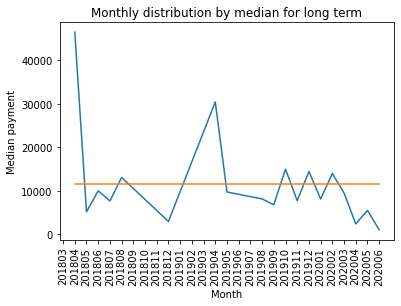

dialysis --> corr_coef: 0.11341195049337842 --> p-value: 0.5506954964399359


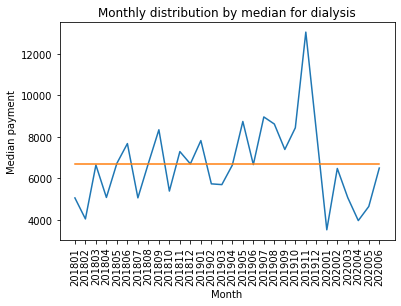

ambulance service --> corr_coef: 0.00197792695692095 --> p-value: 0.9917235297580465


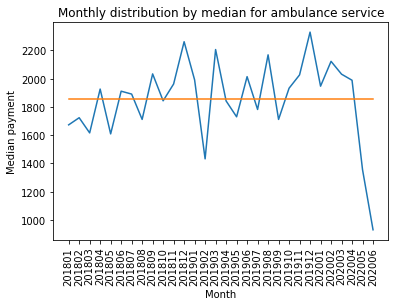

home --> corr_coef: -0.6047007937506313 --> p-value: 0.00040090201551917613


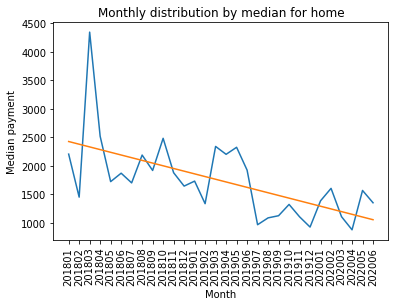

infusion --> corr_coef: 0.33621129408152717 --> p-value: 0.06928594951186588


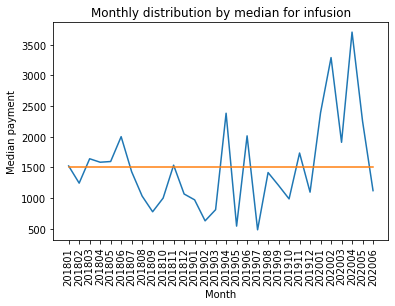

In [65]:
for i in range(5):
    cat = medians.Speciality.values[i]
    avg = []
    for month in sorted(pd.unique(data.MONTH)):
        avg.append(np.median(data[(data.MONTH == month) & (data[cat] == 1)].PAID_AMOUNT))
    plot = pd.DataFrame({'month':list(range(len(pd.unique(data.MONTH)))),'value':avg})
    plot = plot[pd.notna(plot.value)]
    x = plot.month
    y = plot.value
    corr = pearsonr(y,x)
    plt.plot(x,y)
    print(cat,'--> corr_coef:',corr[0],'--> p-value:',corr[1])

    plt.xticks(range(len(pd.unique(data.MONTH))), sorted(pd.unique(data.MONTH)), rotation=90) 
    plt.xlabel('Month')
    plt.ylabel('Median payment')
    plt.title('Monthly distribution by median for '+cat)
    
    a = corr[0]*(corr[1]<0.05)*np.std(y)/np.std(x)
    b = np.mean(y)-a*np.mean(x)
    
    y1 = a*min(x)+b
    y2 = a*max(x)+b
    
    plt.plot([min(x),max(x)],[y1,y2])
    
    plt.show()

For the top specialities by median payment we can see the significant (0.05 threshold) trend for:
- home (correlation: -0.60, p_value: 0.0004)
- hospital (correlation: 0.46, p_value: 0.01)

Payer F --> corr_coef: -0.35472418489540486 --> p-value: 0.05442710261042485


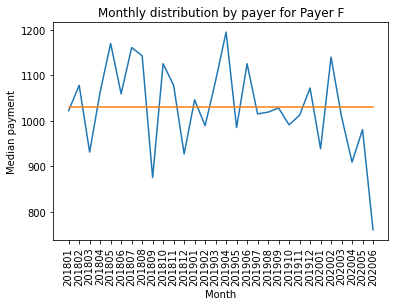

Payer H --> corr_coef: 0.1342354948437787 --> p-value: 0.47943758557549215


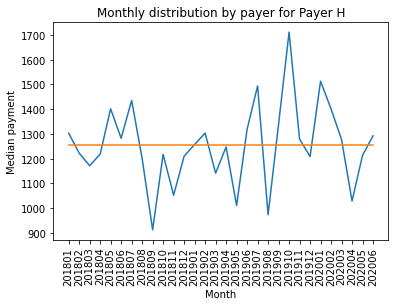

Payer O --> corr_coef: -0.5537476680881521 --> p-value: 0.0015006959768256332


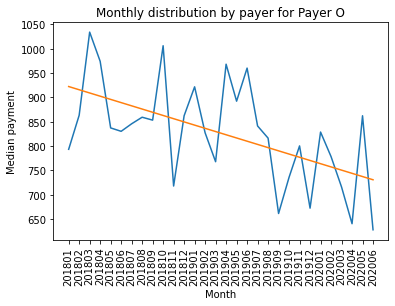

Payer W --> corr_coef: -0.1340543304851863 --> p-value: 0.4800362644441857


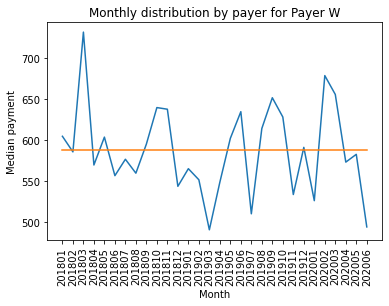

Payer CA --> corr_coef: -0.33589995639861936 --> p-value: 0.06956029961543066


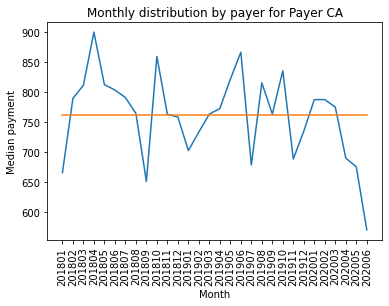

Payer CO --> corr_coef: 0.5394459004591824 --> p-value: 0.002095670825129852


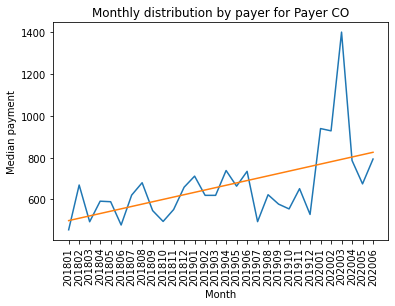

Payer S --> corr_coef: -0.4474623809781648 --> p-value: 0.013162094617099218


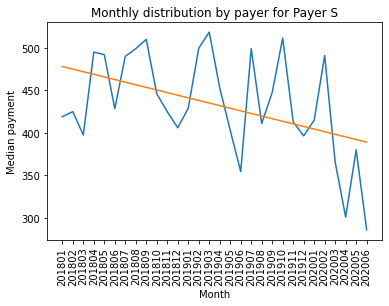

Payer B --> corr_coef: 0.44893165150710146 --> p-value: 0.01282889657371473


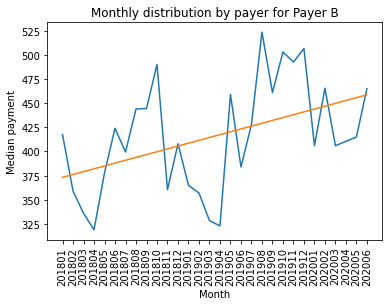

Payer UN --> corr_coef: 0.2846193125394907 --> p-value: 0.12740626211597295


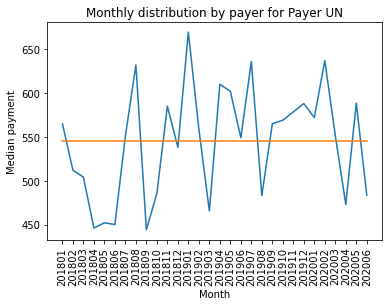

Payer UL --> corr_coef: 0.34863808611306984 --> p-value: 0.1319400938083967


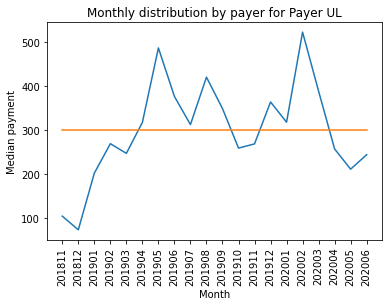

In [66]:
for payer in pd.unique(data.PAYER):
    avg = []
    for month in sorted(pd.unique(data.MONTH)):
        avg.append(np.median(data[(data.MONTH == month) & (data.PAYER == payer)].PAID_AMOUNT))
    plot = pd.DataFrame({'month':list(range(len(pd.unique(data.MONTH)))),'value':avg})
    plot = plot[pd.notna(plot.value)]
    x = plot.month
    y = plot.value
    corr = pearsonr(y,x)
    plt.plot(x,y)
    print(payer,'--> corr_coef:',corr[0],'--> p-value:',corr[1])

    plt.xticks(range(len(pd.unique(data.MONTH))), sorted(pd.unique(data.MONTH)), rotation=90) 
    plt.xlabel('Month')
    plt.ylabel('Median payment')
    plt.title('Monthly distribution by payer for '+payer)
    
    a = corr[0]*(corr[1]<0.05)*np.std(y)/np.std(x)
    b = np.mean(y)-a*np.mean(x)
    
    y1 = a*min(x)+b
    y2 = a*max(x)+b
    
    plt.plot([min(x),max(x)],[y1,y2])
    
    plt.show()

For the top specialities by sum we can see the significant (0.05 threshold) trend for:

- Payer O (correlation: -0.55, p_value: 0.001)
- Payer CO (correlation: 0.54, p_value: 0.002)
- Payer S (correlation: -0.44, p_value: 0.01)
- Payer B (correlation: 0.45, p_value: 0.01)

### Looking most frequent specialities by payer

In [67]:
for payer in pd.unique(data.PAYER):
    temp = data[data.PAYER == payer]
    sums = []
    for cat in speciality_list.keys():
        sums.append(sum(temp[cat]))
        
    res = pd.DataFrame({'cats':list(speciality_list.keys()),'sums':sums})
    res = res.sort_values(by=['sums'],ascending=False)
    print(payer,res.cats.values[0])

Payer F surgery
Payer H nurse
Payer O surgery
Payer W otolaryngology
Payer CA surgery
Payer CO surgery
Payer S otolaryngology
Payer B otolaryngology
Payer UN surgery
Payer UL physical


### Looking most median payment specialities by payer

In [68]:
for payer in pd.unique(data.PAYER):
    temp = data[data.PAYER == payer]
    sums = []
    for cat in speciality_list.keys():
        temp_2 = temp[temp[cat] == 1]
        sums.append(np.median(temp_2.PAID_AMOUNT))
        
    res = pd.DataFrame({'cats':list(speciality_list.keys()),'sums':sums})
    res = res.sort_values(by=['sums'],ascending=False)
    print(payer,res.cats.values[0])

Payer F dialysis
Payer H hospital
Payer O home
Payer W long term
Payer CA hospital
Payer CO durable
Payer S long term
Payer B long term
Payer UN long term
Payer UL audiology


### Looking most frequent specialities goes with surgery

In [69]:
temp = data[data['surgery'] == 1]

sums = []
for cat in speciality_list.keys():
    sums.append(np.sum(temp[cat]))
res = pd.DataFrame({'cats':list(speciality_list.keys()),'sums':sums})

res = res.sort_values(by=['sums'],ascending=False)
res.head(10)

,cats,sums
81,surgery,6047
24,general,1087
90,vascular,914
55,orthopedic,909
83,thoracic,615
8,cardiology,583
65,plastic surgery,504
48,neurology & neurophysiology,491
56,otolaryngology,392
10,colon & rectal,333


### Looking most frequent concurrence between specialities

In [70]:
all_cats = list(speciality_list.keys())

for i in range(len(all_cats)-1):
    general_cat = all_cats[i]
    temp = data[data[general_cat] == 1]

    sums = []
    for j in range(i+1,len(all_cats)):
        cat = all_cats[j]
        sums.append(np.sum(temp[cat]))
    res = pd.DataFrame({'cats':all_cats[i+1:],'sums':sums})

    res = res.sort_values(by=['sums'],ascending=False)
    for j in range(len(res)):
        if res.sums.values[j] >= 100 and res.cats.values[j] != general_cat:
            print(general_cat,'-->',res.cats.values[j],'-->',res.sums.values[j])

ambulance service --> surgery --> 288
ambulance service --> otolaryngology --> 282
anatomic --> pathology --> 205
anesthesia --> nurse --> 264
cardiology --> vascular --> 634
cardiology --> otolaryngology --> 602
cardiology --> interventional --> 602
cardiology --> surgery --> 583
cardiology --> physiology --> 412
cardiology --> thoracic --> 303
colon & rectal --> surgery --> 333
critical care --> surgery --> 163
dental --> otolaryngology --> 437
diagnostic --> radiology --> 862
diagnostic --> sleep --> 139
durable --> otolaryngology --> 185
family --> nurse --> 196
gastroenterology --> otolaryngology --> 1077
general --> surgery --> 1087
gynecology --> oncology --> 165
hematology --> oncology --> 758
interventional --> otolaryngology --> 1155
interventional --> radiology --> 511
interventional --> vascular --> 166
mental --> otolaryngology --> 140
neurology & neurophysiology --> urology --> 854
neurology & neurophysiology --> surgery --> 491
neurology & neurophysiology --> radiology -

## Summary

Preprocessing
- Analyzed the structure of the dataset
- Filtered strange rows with not positive payments
- Corrected errors by creating new speciality list and features

Analyzed
- Payers by paid_amount distribution
- Service category distributions by payer
- Payment distributions by payer

Analyzed trends
- Top specialities by count
- Top specialities by sum paid
- Top specialities by median payment
- Median payment by payer by month
- Correlations between specialities

Discovered:
- The data collecting process may have errors
- Service speciality list have overlaps
- Claim speciality list is not structured and have mistypes and missed data
- 'Payer UL' has lowest median paid_amount
- 'Payer H' has highest median paid_amount
- Top-5 specialities by count: surgery, otolaryngology, radiology, cardiology, oncology	
- Top-5 specialities by sum: hospital, otolaryngology, oncology, surgery, radiology	
- Top-5 specialities by median payment: long term, ambulance service, home, infusion, hospital	

For the top specialities by count we can see the significant (0.05 threshold) trend for:

- otolaryngology (correlation: -0.39, p_value: 0.03)
- oncology (correlation: 0.39, p_value: 0.03)

For the top specialities by sum we can see the significant (0.05 threshold) trend for:

- hospital (correlation: 0.46, p_value: 0.01)
- otolaryngology (correlation: -0.39, p_value: 0.03)
- oncology (correlation: 0.40, p_value: 0.03)

For the top categories by median payment we can see the significant (0.05 threshold) trend for:

- home (correlation: -0.60, p_value: 0.0004)
- hospital (correlation: 0.46, p_value: 0.01)

Most frequent categories for payers are
- Payer F: surgery
- Payer H: nurse
- Payer O: surgery
- Payer W: otolaryngology
- Payer CA: surgery
- Payer CO: surgery
- Payer S: otolaryngology
- Payer B: otolaryngology
- Payer UN: surgery
- Payer UL: physical

Most expensive categories for payers are
- Payer F: home
- Payer H: hospital
- Payer O: home
- Payer W: long term
- Payer CA: hospital
- Payer CO: durable
- Payer S: long term
- Payer B: long term
- Payer UN: long term
- Payer UL: audiology

Most frequent categories for surgery are:
- general
- vascular
- orthopedic
- thoracic
- cardiology
- plastic surgery
- neurology & neurophysiology
- otolaryngology
- colon & rectal

Also discovered most frequent correlations between categories

Information could be useful for the Ministry of Health, hospitals as well as for insurance companies